# Optimize Gaussian Parameters in 2D for Synthetic Data and Image

In this notebook, we'll be optimizing for 2D Gaussians to represent images, while building up the intuition that generalizes to 3D Gaussian Splatting.

In Part 0, we'll create the building blocks for Gaussian representations.
In Part 1, we'll be targeting a "synthetic" image (originally reconstructed from Gaussians).
In Part 2, we'll be optimizing for an actual target image.
In Part 3, we'll move our optimized target image representation to the GLSL shader to view our animated optimization.

For inspiration, here are a couple of cool examples on shadertoy of what you could do with your 2D Gaussian image once you work through this notebook:
- [https://www.shadertoy.com/view/tflXRB](https://www.shadertoy.com/view/tflXRB)
- [https://www.shadertoy.com/view/dtSfDD](https://www.shadertoy.com/view/dtSfDD)
- [https://www.shadertoy.com/view/MdfGDH](https://www.shadertoy.com/view/MdfGDH)
- [https://www.shadertoy.com/view/4df3D8](https://www.shadertoy.com/view/4df3D8)
- [https://www.shadertoy.com/view/4XXSDN](https://www.shadertoy.com/view/4XXSDN)



## Imports

In [ ]:
# Core
import numpy as np
import math
import torch
from torch import nn
import random

# Visu
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt

# file i/o
import pathlib
from pathlib import Path
import json

# For assembling video
import cv2
import glob

# Misc.
from typing import Union
from datetime import datetime
from tqdm import tqdm  # progress bar
TIME_FORMAT = "%Y-%m-%d %H:%M:%S"

# Check if notebook is running on a Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print(f"IN_COLAB {IN_COLAB}")

IN_COLAB True


In [ ]:
#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Choose between available PyTorch backends. Use GPU if available.
DEVICE = torch.device('cpu')
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  # Metal backend for Apple devices
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')  # Cuda backend for Nvidia GPUs

print(f"Using {DEVICE} backend (torch.device)")

Using cuda backend (torch.device)


# Helper classes and functions

You don't need to touch anything here.
They are included here only to make the notebook self-contained, and include the following functionalities used in throughout the notebook:
- Domain2D: handles the 2D domain and its discretization
- Simplify handling input/output paths and filenames
- Plotting helper functions
- Very simple Timer class
- Writing out parameters as JSON and assembling video

If you're curious, feel free to dig in, though.

In [ ]:
#@title Domain2D
class Domain2D:
    """
    Helper function for handling a 2D domain, discretized on a grid of given resolution.
    """
    x_dim: tuple[float]
    y_dim: tuple[float]
    res_x: float
    res_y: float
    xx: torch.Tensor
    yy: torch.Tensor

    def __init__(self, x_dim, y_dim, res_x, res_y):
        self.x_dim, self.y_dim = x_dim, y_dim
        self.res_x, self.res_y = res_x, res_y

        self.xx, self.yy = torch.meshgrid(
            torch.linspace(self.x_dim[0], self.x_dim[1], self.res_x, device=DEVICE),
            torch.linspace(self.y_dim[0], self.y_dim[1], self.res_y, device=DEVICE),
            indexing='xy'
        )

    def __str__(self):
        return (f"Domain2D: {self.x_dim}x{self.y_dim} "
                f"discretized on a {self.res_x}x{self.res_y} grid.")

    def get_extent(self):
        extent = (*self.x_dim, *self.y_dim)
        return extent

In [ ]:
#@title Files and folders

CURRENT_SCENE = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
DATA_FOLDER = pathlib.Path("data")
CURRENT_SCENE_FOLDER = DATA_FOLDER / pathlib.Path(CURRENT_SCENE)
LAST_FILE_NAME = 0

def save_fig_to_file(fig):
    # Save plot to file as {curr_date}/{epoch}.jpg
    global LAST_FILE_NAME
    curr_image_file = CURRENT_SCENE_FOLDER / f"{LAST_FILE_NAME}.jpg"
    fig.savefig(curr_image_file.absolute())

    LAST_FILE_NAME += 1

def initialize_file_names():
    """
    Update current folder name and reset file names.
    We might want to call this when a new optimization run starts.
    """
    global LAST_FILE_NAME, CURRENT_SCENE, CURRENT_SCENE_FOLDER

    CURRENT_SCENE = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    CURRENT_SCENE_FOLDER = DATA_FOLDER / pathlib.Path(CURRENT_SCENE)

    CURRENT_SCENE_FOLDER.mkdir(parents=True, exist_ok=True)
    LAST_FILE_NAME = 0

initialize_file_names()

In [ ]:
#@title Plotting

def plot_tensor_image(
        image,
        title: str = "",
        _plt=plt,
        extent=None,
):
    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()

    if image.shape[-1] == 3:
        image = np.clip(image, 0, 1)
        # plot (R,G,B) image
        #  Clip image colors

    _plt.imshow(
        image,
        extent=extent,  # (left, right, bottom, top)
        origin="lower"
    )

    if _plt == plt:
        _plt.title(title)
    else:
        _plt.title.set_text(title)


def draw_outline(params, _plt=plt):
    centers, sigmas, thetas = params["centers"], params["sigmas"], params["thetas"]
    # Convert to basic numpy array if necessary,
    # bringing tensors to the cpu and detach from computing graph
    if isinstance(centers, torch.Tensor):
        centers = centers.cpu().detach().numpy()
    if isinstance(sigmas, torch.Tensor):
        sigmas = sigmas.cpu().detach().numpy()
    if isinstance(thetas, torch.Tensor):
        thetas = thetas.cpu().detach().numpy()

    if not isinstance(_plt, plt.Axes):
        _plt = _plt.gca()

    # plot centers as red dots
    _plt.scatter(x=centers[:, 0], y=centers[:, 1], c='r', s=1)

    # draw ellipses
    for i, c in enumerate(centers):
        _plt.add_patch(
            Ellipse(
                (c[0], c[1]),
                width=sigmas[i][0] * 3.5,
                height=sigmas[i][1] * 3.5,
                angle=thetas[i] * (180.0 / np.pi),
                edgecolor='red',
                facecolor='none',
                linewidth=1,
                alpha=1.0
            )
        )


def assemble_plot_data(data, outline_params):
    """
    Make the data ready for plotting with the `plot` function.
    Calculates the number of rows and columns to be plotted based on the supplied data.

    :param data: image data, or iterable of image data
    :param outline_params: gaussian parameters used for plotting an overlay over the reconstructed image
    :return: number of columns (int), rows (int), assembled data (np.ndarray) and outline parameters (list)
    """

    def is_iterable(x):
        return isinstance(x, list) or isinstance(x, tuple)

    def is_2d_iterable(x):
        return isinstance(x[0], list) or isinstance(x[0], tuple)

    def get_numpy_data(d):
        # Takes a single piece of plottable data, and makes it a numpy array
        if isinstance(d, torch.Tensor):
            d = d.cpu().detach().numpy()
        d = np.array(d)
        return d

    # Create a 2D array of plottable data [[row_1_1, row_1_2 ...],[row_2_1, row_2_2, ...], ...]
    # Each piece of data is uniformly converted to a numpy array
    new_data = []
    if is_iterable(data):
        if is_2d_iterable(data):
            for i in range(len(data)):
                curr_row = []
                for j in range(len(data[i])):
                    curr_data = get_numpy_data(data[i][j])
                    curr_row.append(curr_data)
                new_data.append(curr_row)
        else:
            single_row = []
            for i in range(len(data)):
                curr_data = get_numpy_data(data[i])
                single_row.append(curr_data)
            new_data.append(single_row)
    else:
        # Single piece of data, but we still create a 2D array
        new_data.append([get_numpy_data(data)])

    data = new_data

    # Calculate number of rows and columns in the plot
    nrows = len(data)
    ncols = len(data[0])

    # Handle outline_params
    if isinstance(outline_params, dict):
        # If plotting only a single piece of data
        assert ncols == nrows == 1, "Non-list outline params is only allowed for plotting a single data."
        outline_params = [[outline_params]]
    if outline_params is not None:
        if not all(p is None for p in outline_params):
            if not isinstance(outline_params[0], list):
                # If not already a 2D array, then
                # wrap outline_params to be a 2D array for [row][col] indexing
                outline_params = [outline_params]
        else:
            outline_params = None

    # We could assert that outline_params should be None, or having the same shape as the data

    return ncols, nrows, data, outline_params


def assemble_titles(title, ncols, nrows):
    """
    :param title: string or list of strings
    :param ncols: number of columns in the plot
    :param nrows: number of rows in the plot
    :return: a 2D list of titles corresponding to a (ncols, nrows) plot.
    """
    if isinstance(title, (tuple, list, dict)):
        if isinstance(title[0], (tuple, list, dict)):
            # Title is a 2D array of titles for each subplot, individually
            assert len(title) == nrows and len(title[0]) == ncols
        else:
            # Wrap 1D list of titles to be a 2D array for a single row
            title = [title]
    else:
        # Same title for each subplot
        title = [[title] * ncols] * nrows

    return title


def plot(
        data: Union[torch.Tensor, list, tuple, np.ndarray],
        title: Union[str, list] = "",
        figsize=(16, 6),
        extent=None,
        domain: Domain2D = None,  # if domain is not None, then it overwrite extent, xx and yy
        outline_params=None,
        show_plot=True,
):
    """
    Main plotting function.
    """
    ncols, nrows, data, outline_params = assemble_plot_data(data, outline_params)
    titles = assemble_titles(title, ncols, nrows)

    # Shape of axs, and existence of dimensions is dependent on number of rows and columns. If figure is (1,1)
    # or either ncols or nrows is 1, then at least 1 of the dimensions will be missing from the axs list.
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)

    # Make sure that axs is a 2D list of all subplot axes which can be indexed as `axs[row_i][col_j]`.
    if nrows == ncols == 1:
        axs = [[axs]]
    elif nrows == 1:
        axs = [axs]  # axs is a 1D list
    elif ncols == 1:
        axs = [[axs[i]] for i in range(len(axs))]  # axs is a 1D list, but we have to reshape it

    # Set extent, xx and yy from domain if it was supplied
    if domain is not None:
        extent = domain.get_extent()

    for i in range(nrows):
        for j in range(ncols):
            curr_data = data[i][j]
            curr_ax = axs[i][j]
            curr_title = titles[i][j]

            if len(curr_data.shape) > 1:
                # Plot scalar field or image data
                plot_tensor_image(
                    image=curr_data,
                    title=curr_title,
                    _plt=curr_ax,
                    extent=extent,
                )
                if outline_params is not None and outline_params[i][j] is not None:
                    draw_outline(params=outline_params[i][j], _plt=curr_ax)
                curr_ax.set_aspect('equal')
            elif len(curr_data.shape) == 1:
                # Plot 1D data, e.g. loss curve
                curr_ax.plot(curr_data)
                curr_ax.set_xticks(range(0, len(curr_data), math.ceil(len(curr_data) / 8)))
                curr_ax.set_title('Learning curve')
                curr_ax.set_xlabel('Epoch')
                curr_ax.set_ylabel('Loss')

    if show_plot:
        plt.show()

    return fig

In [ ]:
#@title Timer
class Timer:
    """
    Super simple utility class for displaying elapsed time.
    """

    def __init__(self):
        self.init_time = datetime.now()
        # Step 1: Print the current time
        print("Current time:", self.init_time.strftime(TIME_FORMAT))

    def print_time(self, reset_time = False):
        # Print the time and the time elapsed since init_time
        current_time = datetime.now()
        elapsed_time = current_time - self.init_time

        print("Current time:", current_time.strftime(TIME_FORMAT))
        print("Time elapsed:", str(elapsed_time))

        # Optionally overwrite initial time
        if reset_time:
            self.init_time = current_time

    def get_elapsed_time(self) -> str:
        delta_time = datetime.now() - self.init_time
        return "{:02}:{:02}:{:02}".format(
                delta_time.seconds // 3600,
                (delta_time.seconds % 3600) // 60,
                (delta_time.seconds % 60) // 1,
                )

In [ ]:
#@title Misc.: json i/o and video

def gaussians_from_json_file(filename):
    filepath = pathlib.Path(filename)
    filepath = CURRENT_SCENE_FOLDER / filepath

    json_data = dict()

    with open(filepath, 'r') as file:
        data = json.load(file)
        # TODO check for invalid input data here

        json_data['gaussians'] = dict()
        json_data['gaussians']['alphas']  = data['alphas']
        json_data['gaussians']['centers'] = data['centers']
        json_data['gaussians']['sigmas']  = data['sigmas']
        json_data['gaussians']['thetas']  = data['thetas']

        json_data['N']     = data['N']
        json_data['dims']  = data['dims']
        json_data['x_dim'] = data['x_dim']
        json_data['y_dim'] = data['y_dim']
        json_data['res_x'] = data['res_x']
        json_data['res_y'] = data['res_y']

    print(f"Read gaussian scene from {filepath} with "
          f"N={json_data['N']}, dims={json_data['dims']}, gaussians#={len(json_data['gaussians'])}"
          f"#alphas={len(json_data['gaussians']['alphas'])}, "
          f"#centers={len(json_data['gaussians']['centers'])}, "
          f"#sigmas={len(json_data['gaussians']['sigmas'])}, "
          f"#thetas={len(json_data['gaussians']['thetas'])}")

    return json_data


def gaussians_to_json_file(filename, params, domain):
    """
    filename: relative to the current scene
    """
    filepath = CURRENT_SCENE_FOLDER / filename

    # Convert PyTorch tensors to Python floats (and lists of them)
    alphas_item = [[x.item() for x in a] for a in params['alphas']]
    centers_item = [[x.item() for x in c] for c in params['centers']]
    sigmas_item = [[x.item() for x in s] for s in params['sigmas']]
    # Can't array comprehend over 0D tensor
    thetas_item = [t.item() for t in params['thetas']]

    scene_data = {
        "x_dim": domain.x_dim,
        "y_dim": domain.y_dim,
        "res_x": domain.res_x,
        "res_y": domain.res_y,
        "N": params['alphas'].shape[0],
        "dims": params['alphas'].shape[-1],
        "alphas": alphas_item,
        "centers": centers_item,
        "sigmas": sigmas_item,
        "thetas": thetas_item
    }

    with open(filepath, 'w') as file:
        json.dump(scene_data, file, indent=2)

    print(f"2D Gaussian Scene written to {filepath}.")


def assemble_video(image_folder: str, output_file: str="video.mp4", fps=10):
    """
    image_folder: absolute path
    output_file: name of output file
    """
    image_files = sorted(glob.glob(f"{image_folder}/*.jpg"), key=lambda x: int(Path(x).stem))
    if not image_files:
        raise ValueError("No .jpg files found in the specified directory.")

    # Read the first image to get the dimensions
    image_0 = cv2.imread(image_files[0])
    height, width, layers = image_0.shape

    # Adjust FPS based on the number of images
    if len(image_files) > 200:
        fps = 30
    elif len(image_files) > 100:
        fps = 20

    # Create Video Writer with proper codec
    fourcc = cv2.VideoWriter_fourcc(*'FMP4')  # Using H.264 codec
    video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Write frames to video
    for image_file in image_files:
        video.write(cv2.imread(image_file))

    video.release()
    print(f"Video saved as {output_file}")

# Part 0: 2D Gaussian Functions

A 2D Gaussian is parameterized by:
- centers $c = [c_x, c_y]^T$
- scales $\sigma = [\sigma_x, \sigma_y]^T$
- scalar rotation $\theta$ (Note: we could also use a unit-length complex number in the spirit of using quaternions in 3D, but a scalar rotation is perfectly fine.)

Its value at point $\bf{p}$ is given by
$$
f(p) = \text{exp}\left(
  -\frac{1}{2}
  (p - c)^T
  \Sigma^{-1}
  (p - c)
\right),
$$

where the covariance matrix $\Sigma$ describes the shape of the Gaussian, and we build it as

$$
\Sigma =
      RSS^TR^T,
$$

making use of (1) $(AB)^{-1} = B^{-1} A^{-1}$, and (2) $R^{-1} = R^T$ for rotational matrices, we have
$$
\Sigma^{-1} = R(SS^{T})^{-1}R^T.
$$

If we want to write out our 2D Gaussian function explicitly, we have:

$$
f\left(\begin{bmatrix}
    p_x\\
    p_y
\end{bmatrix}\right)
= \text{exp}\left(
    -\frac{1}{2}
    \begin{bmatrix}
        p_x - c_x &
        p_y - c_y
    \end{bmatrix}
    \Sigma^{-1}
    \begin{bmatrix}
        p_x - c_x\\
        p_y - c_y
    \end{bmatrix}
\right),
$$

where
$$
    \Sigma^{-1} =
      \begin{bmatrix}
        \cos \theta & -\sin\theta\\
        \sin \theta & \cos \theta
      \end{bmatrix}
      \begin{bmatrix}
        \frac{1}{\sigma_x^2} & 0 \\
        0 & \frac{1}{\sigma_y^2}
      \end{bmatrix}
      \begin{bmatrix}
        \cos \theta & \sin\theta\\
        -\sin \theta & \cos \theta
      \end{bmatrix}.
$$

To reconstruct a 2D image, we add together function of this form, but also multiply them by an "alpha" channel. In the original 3DGS implementation, they use a Gaussian-wise $\alpha \in \mathbb{R}$ and RGB color $[c_r, c_g, c_b] \in \mathbb{R}^3$ (converted from spherical harmonics in 3D, given our current view direction).

To simplify things here, we multiply these together, and store $\boldsymbol{\alpha} = \alpha \cdot [ c_r, c_g, c_b ]$ for each Gaussian.

Thus, we reconstruct each pixel $\textbf{p}$ of our 2D image $\textbf{I}$ by summing together to contribution from N Gaussians as

$$
I(p) = \sum_{i=1}^{N} \boldsymbol{\alpha}_i f_i(p).
$$

This is already implemented in `reconstruct_gaussian_2d` below, with two helper functions: `build_sigma_invs` and `build_position_tensor`.

## Part 0.1: Build The Inverse Covariance Matrix

Here, you will build the inverse covariance matrix for a single 2D Gaussian, using the provided rotation and scale vector.
In order to do this, you must build the rotation matrix R and the diagonal inverse scaling matrix D (seen above as (SS^T)).

In [ ]:
def build_single_sigma_inv(theta: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    """
    Compute the inverse covariance matrix for a single 2D Gaussian,
    given a rotation (theta) and a scale vector (sigma).

    theta: shape (1), a scalar tensor representing the rotation angle.
    sigma: shape (2) a tensor representing the scales in x and y directions.

    Returns:
        A 2x2 tensor representing the inverse covariance matrix.
    """
    # Construct the 2x2 rotation matrix R.
    R = torch.eye(2, device=DEVICE)  # create a 2x2 matrix
    # Populate the elements of this matrix using R[row, column] indexing.

    ##########
    # BEGINNING OF YOUR CODE.
    ##########

    R[0, 0] = torch.cos(theta)
    R[0, 1] = -torch.sin(theta)
    R[1, 0] = torch.sin(theta)
    R[1, 1] = torch.cos(theta)

    ##########
    # END OF YOUR CODE
    ##########

    # Construct the 2x2 diagonal inverse scaling matrix.
    # Here, sigma is assumed to be a vector: [sigma_x, sigma_y].

    D = torch.eye(2, device=DEVICE)  # 2x2 identity matrix
    # Hint: How should you tweak the elements of a 2x2 identity matrix to scale it by sigma?

    # Make sure that sigma**2 is not zero to avoid division by zero.
    sigma_sqare_safe = sigma**2 + 1e-6
    ##########
    # BEGINNING OF YOUR CODE
    ##########

    D[0][0] = 1 / sigma_sqare_safe[0]
    D[1][1] = 1 / sigma_sqare_safe[1]
    D[0][1] = 0
    D[1][0] = 0

    ##########
    # END OF YOUR CODE
    ##########

    # Compute the inverse covariance matrix: sigma_inv = R @ D @ R.T
    sigma_inv = R @ D @ R.T
    return sigma_inv


def build_position_tensor(p_x: torch.Tensor, p_y: torch.Tensor, center: torch.Tensor) -> torch.Tensor:
    """
    Construct a tensor of relative positions for a single Gaussian,
    given grid coordinates and a 2D center.

    p_x: (res_y, res_x) of x-coordinates of the grid (image pixel) positions.
    p_y: (res_y, res_x) of y-coordinates of the grid (image pixel) positions.
    center: A tensor with the Gaussian center (shape: [2]).

    A tensor of relative positions with shape [res_y, res_x, 2].
    """
    # Combine the x and y coordinates into and [res_y, res_x, 2] grid.
    p_grid = torch.stack([p_x, p_y], dim=-1)
    # Subtract the center to obtain relative positions.
    pos = p_grid - center
    return pos

## Part 0.2: Accumulate contribution of Gaussians for image field

Here, you will reconstruct the image by sampling multiple 2D Gaussians over a given 2D domain.

In order to do this for each gaussian, you must apply the inverse covariance matrix to the Gaussian's position to get the transformed position and apply the function f(p) to the transformed position as seen in the equation block above.

Finally, you must multiply the alpha of the gaussian by the gaussian's contribution value f(p) to get the weighted contribution of this Gaussian that can be added to the image field.

In [ ]:

def reconstruct_image(params: dict, domain) -> torch.Tensor:
    """
    Sample multiple 2D Gaussians over a given 2D domain in a non-batched manner.
    Each Gaussian is defined by its alpha (rgb colors*opacity), center, sigma (scale) and theta (rotation).
    The final field (rgb image) is the sum of the contributions of each Gaussian.

    Returns:
        A tensor representing the aggregated image (shape: [res_x, res_y, 3]).
    """
    alphas = params['alphas']  # shape (N, 3)
    centers = params['centers']  # shape (N, 2)
    sigmas = params['sigmas']  # shape (N, 2)
    thetas = params['thetas']  # shape (N)

    N = alphas.shape[0]
    # (res_x, res_y, 3)-shaped image with RGB colors.
    field = torch.zeros((domain.xx.shape[0], domain.xx.shape[1], 3), dtype=torch.float32, device=DEVICE)

    for i in range(N):
        # Compute the inverse covariance matrix for the i-th Gaussian.
        sigma_inv = build_single_sigma_inv(thetas[i], sigmas[i])

        # Build the position tensor relative to the i-th Gaussian's center.
        pos = build_position_tensor(domain.xx, domain.yy, centers[i])

        # Compute the quadratic form: exponent = pos^T @ sigma_inv @ pos, for each grid point.
        # Hint: torch.matmul is also accessible as the operator @

        # Evaluate the Gaussian function: f(x) = exp(-0.5 * exponent)

        # Accumulate the weighted contribution of this Gaussian.
        # Hint: alphas[i] is (r,g,b), while f_i is (res_y, res_x).
        # When multiplying the two, make sure that they broadcast properly, e.g. by adding an empty (length-1) last dimension to f_i

        ##########
        # BEGINNING OF YOUR CODE
        ##########

        exponent = (pos @ sigma_inv * pos).sum(dim=-1)
        f_i = torch.exp(-0.5 * exponent)
        field += f_i.unsqueeze(-1) * alphas[i]

        ##########
        # END OF YOUR CODE
        ##########

    # replace possible NaNs with 0
    field = torch.nan_to_num(field)

    return field


# Part 1: Optimize for Synthetic Ground Truth
## Part 1.1. Generate Synthetic Ground Truth

Let's test out the above functionalities by reconstructing a 2D Image from our Gaussians.

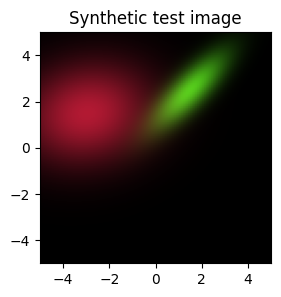

In [ ]:
DOMAIN = Domain2D(
    x_dim=[-5.0, 5.0],  # virtual dimensions
    y_dim=[-5.0, 5.0],
    res_x=100,  # resolution
    res_y=100
)

# Define the parameters in a dictionary.
# Create torch tensors on the selected computing device (cpu/metal/cuda).
target_params = {
    # RGB colors
    'alphas': torch.tensor([
        [0.7, 0.1, 0.2],
        [0.3, 0.8, 0.1]
    ], device=DEVICE),
    # X,Y coordinates
    'centers': torch.tensor([
        [-3.0, 1.5],
        [1.5, 2.5]
    ], device=DEVICE),
    # Scales along local (X, Y)
    'sigmas': torch.tensor([
        [2.0, 1.5],
        [1.5, 0.5]
    ], device=DEVICE),
    # Rotations
    'thetas': torch.tensor([
        0.2, 0.8
    ], device=DEVICE)
}

# Reconstruct the 2D Gaussians on a 2D grid.
# Note: the detach() function is needed, because we just want to generate some static
#   synthetic target image data. If we didn't detach, then the computation that produced
#   it would become part of PyTorch's computation graph when we calculate the loss later on.
#   Or put simply: we just want a plain array of numbers.
target_image_synthetic = reconstruct_image(target_params, domain=DOMAIN).detach()

# Plot the target scene using the helper plotting function
plot(data=target_image_synthetic, title="Synthetic test image", domain=DOMAIN, figsize=(3,3));

## Part 1.2. Initial random Gaussian parameters for the optimization

Now we run a simple experiment: let's forget that the above "ground truth image" came from our predefined Gaussians. Can we find a set of Gaussian parameters that describe the same image?

Let's generate a random set of Gaussian parameters, and look at what that gives us.

In [ ]:
N = 20  # Number of Gaussians

# Collect the parameters we want to optimize in a dictionary.
# Feel free to play around with the random initialization!
params_opt_synthetic = {
    # get random RGB color for N gaussian
    'alphas': nn.Parameter(torch.tensor(
        [[random.random() for _ in range(3)] for _ in range(N)],
        requires_grad=True, device=DEVICE
    )),
    # positions: scatter N random gaussians in our domain
    'centers': nn.Parameter(torch.tensor(
        [[random.uniform(*DOMAIN.x_dim), random.uniform(*DOMAIN.y_dim)] for _ in range(N)],
        requires_grad=True, device=DEVICE
    )),
    # Scales along local (X, Y). Start out with isotropic gaussian
    'sigmas': nn.Parameter(torch.tensor(
        [[1.5, 1.5] for _ in range(N)],
        requires_grad=True, device=DEVICE
    )),
    # Rotations
    'thetas': nn.Parameter(torch.tensor(
        [0.0]*N, # or for random rotation: np.random.rand() * 2 * np.pi
        requires_grad=True, device=DEVICE
    )),
}

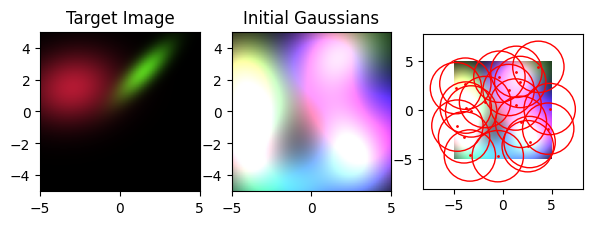

In [ ]:
# Plotting initial gaussians
initial_image = reconstruct_image(
    params_opt_synthetic,
    domain=DOMAIN
)

plot(
    data=[target_image_synthetic, initial_image, initial_image],
    title=["Target Image", "Initial Gaussians", ""],
    outline_params=[None, None, params_opt_synthetic],
    extent=DOMAIN.get_extent(),
    figsize=(7,10)
);

## Part 1.3: Customized Gaussian Optimization

Come up with a more fun, complex "synthetic" target image by modifying our initial gaussian parameters in Part 1.1. Run Part 1 with your new "synthetic" image and save the results. Feel free to change the number of Gaussians, just make sure to have the same number of colors, positions, scales, and rotations defined in each tensor (i.e. match their first dimension).

## REFLECTION QUESTION 1.
- You might see a white blob where Gaussians are overlapping, instead of some nice colors.
- Why is this happening in our model?
- How could we improve this? Is there an easy fix?

Hint: what's the difference between our 2D Gaussians and the z-index-based alpha blending we looked at in class?

(YOUR ANSWER HERE)

Answer: In this 2D Gaussian Splending model, we sum the colors from different Gaussians directly, rather than using a coefficient to blend them. This approach can result in excessively high radiance (color) for pixels covered by multiple Gaussians.

To address this issue, we can manually introduce an additional alpha channel and an order ID for all Gaussians. When calculating the fragment color, the alpha value serves as a blending coefficient, adjusting the color transition between Gaussians based on their assigned order.

## Part 1.3. Optimization

Now let's tweak our initial Gaussians. We would like the image reconstructed from them to be the same as our ground truth image $\textbf{I}$. Calling our set of Gaussian parameters $\xi$ (containing alphas, centers, sigmas, and thetas), we can quantify this in a scalar-valued loss function:

$$
    \mathcal{L}(\textbf{I}, \xi) =
    \sum_{\text{pixels \textbf{p}} \in \text{\textbf{I}}}
        ||
            \boldsymbol{I}(\boldsymbol{p}) - \sum_{i}^N \boldsymbol{\alpha}_i f_i(\boldsymbol{p}; \xi_i)
        ||,
$$

where $f_i(\cdot;\xi_i)$ simply denotes that we are using the $i$th Gaussian parameters.

### Part 1.3.1 Initialize the optimizer
Initialize the learning rate, optimizer, and loss function for Gaussian optimization.

For this notebook, both $L_1$ and $L_2$ losses work fine. In the original 3DGS paper, they add together a D-SSIM loss with a weight of $0.2$ and an $L_1$ loss with a weight of $0.8$ to get their scalar loss.

To find Gaussian parameters $\xi$ that minimize this loss function, we use an Adam optimizer that iteratively steps towards the gradient of the loss w.r.t. the parameters.

In [ ]:
params_keys = ['alphas', 'centers', 'sigmas', 'thetas']  # Note: params_opt.keys() is unordered.
params_dict_for_optimizer = [{'params': params_opt_synthetic[p], 'name': p} for p in params_keys]
# Note: this is the same as:
# params_dict_for_optimizer = [
#     {'params': params_opt_synthetic['alphas'], 'name': 'alphas'},
#     {'params': params_opt_synthetic['centers'], 'name': 'centers'},
#     {'params': params_opt_synthetic['sigmas'], 'name': 'sigmas'},
#     {'params': params_opt_synthetic['thetas'], 'name': 'thetas'}
# ]

# We can also set per-parameter-group learning rates beyond the default learning rate below.
# We can use this for freezing a given parameter group (e.g. leave particles in the same position).
# For more details on setting up and using the optimizer: https://pytorch.org/docs/stable/optim.html
# lr_dict = {'alphas': 0.01, 'centers': 0.2, 'sigmas': 0.0, 'thetas': 0.0}
# for i, param_key in enumerate(params_keys):
#     if param_key in lr_dict:
#         params_dict_for_optimizer[i]['lr'] = lr_dict[param_key]


# Define initial default learning rate
lr = None
##########
# BEGINNING OF YOUR CODE
##########

lr = 0.01
lr_dict = {'alphas': 0.01, 'centers': 0.01, 'sigmas': 0.01, 'thetas': 0.01}
for i, param_key in enumerate(params_keys):
    if param_key in lr_dict:
        params_dict_for_optimizer[i]['lr'] = lr_dict[param_key]

##########
# END OF YOUR CODE
##########


# Initialize an Adam optimizer
# See: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = None
##########
# BEGINNING OF YOUR CODE
##########

optimizer = torch.optim.Adam(params_dict_for_optimizer, lr)

##########
# END OF YOUR CODE
##########

# Define the loss function we want to use in the optimization loop below
def loss_function(prediction, target):
    # Create a criterion, such as an L1 or L2 loss. You can also experiment with adding an SSIM loss.
    # Hint: sticking with a simple L1 loss works fine perfect for this assignment.

    loss = None

    ##########
    # BEGINNING OF YOUR CODE
    ##########

    loss = torch.mean(torch.abs(prediction - target))

    ##########
    # END OF YOUR CODE
    ##########

    return loss

### Part 1.3.2 Optimization loop

Implement the optimization loop by following the steps outlined in the comments below.

In [ ]:
image_save_interval = 1  # Whether to same image
num_epochs = 500
display_plots = False  # Whether to plot in the notebook. Useful for not cluttering the notebook.
save_plots = True  # Whether to write out images into a folder.

if save_plots:
    # Set the output folder to be the current time, and restart naming of the file names
    initialize_file_names()
    print(f"Starting optimization. Outputting results into folder `{CURRENT_SCENE_FOLDER}`.")
else:
    print(f"Starting optimization without saving the results into file.")

timer = Timer()

# Keep track of lost history
loss_trajectory = []

epoch_progress_bar = tqdm(range(num_epochs))
for epoch in epoch_progress_bar:
    # Implement the optimization loop.
    # (1) Forward pass, i.e. combining Gaussians into an image
    # (2) Calculate and save current loss between output and target
    #      Hint: don't forget to detach, bring to the cpu and convert to numpy before appending to the loss_trajectory.
    # (3) Zero out gradients before running backward pass
    # (4) Run backward pass: compute gradient of the loss (w.r.t. gaussian parameters)
    # (5) Perform an optimization epoch (i.e. update gaussian parameters) by stepping the optimizer
    # For details, see: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

    ##########
    # BEGINNING OF YOUR CODE
    ##########

    curr_image = reconstruct_image(params_opt_synthetic, DOMAIN)
    curr_loss = loss_function(curr_image, target_image_synthetic)

    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()

    loss_trajectory.append(curr_loss.item())

    ##########
    # END OF YOUR CODE
    ##########

    with torch.no_grad():
        # We don't want gradient calculation for this part.
        # Note: Densification and Pruning could be done here by removing Gaussians
        #       that are too small/stretched/out of bounds/etc,
        #       and duplicating Gaussians based on their positional gradient.

        # Optionally display/save image
        if display_plots or save_plots:
            if epoch % image_save_interval == 0:
                fig = plot(
                    data=[curr_image, curr_image, target_image_synthetic, loss_trajectory],
                    outline_params=[None, params_opt_synthetic, None, None],
                    title=[
                        f"Optim at epoch {epoch}",
                        f"Gaussians (N={N})",
                        f"Target image",
                        f"Loss history"
                    ],
                    domain=DOMAIN,
                    show_plot=display_plots  # Optionally, don't clutter the notebook with showing the plot here.
                )
            if save_plots:
                # Save plot to file as {curr_date}/{epoch}.jpg
                save_fig_to_file(fig)
            plt.close(fig)  # close the current figure

        # Print out optimization details
        progress_text = (
            f"Step {epoch}, "
            f"Loss: {curr_loss.item()}, "
            f"{timer.get_elapsed_time()}, "
            f"N = {N}"
        )

        epoch_progress_bar.set_description(progress_text)

        # You can try experimenting with a learning rate scheduler.
        # In the simplest case, you can decrease the learning rate
        # at some predefined intervals.
        # if epoch % 800 == 0 and epoch > 0:
        #     for param_group in self.optimizer.param_groups:
        #         param_group['lr'] *= 0.5
        #         print(f"lr: {param_group['lr']}")

Starting optimization. Outputting results into folder `data/2025_03_29-02_44_57`.
Current time: 2025-03-29 02:44:57


Step 499, Loss: 0.0007656404050067067, 00:01:40, N = 20: 100%|██████████| 500/500 [01:40<00:00,  4.95it/s]


### Part 1.3.3 Plotting final result

Turn in the image/video of your Gaussian optimization for your customized "synthetic" image by running the methods in this section.

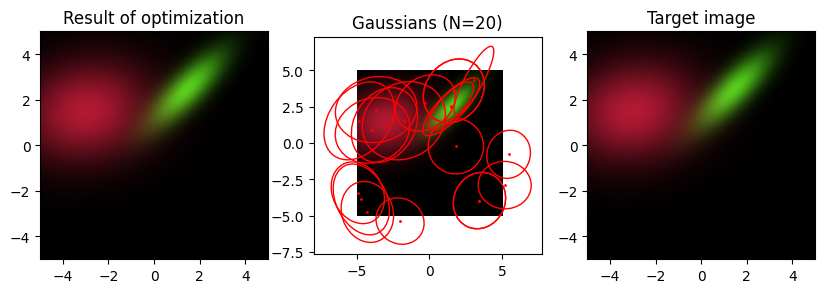

Final params: {'alphas': Parameter containing:
tensor([[ 6.7211e-02, -3.0413e-01,  2.4220e-01],
        [ 1.0266e-01,  2.5103e-02,  1.8394e-02],
        [ 3.7356e-01,  5.3533e-02,  1.0421e-01],
        [ 9.1688e-02,  3.0244e-02,  9.0653e-03],
        [-3.6513e-01,  3.9059e-02,  3.3967e-01],
        [ 1.8230e-01,  1.2345e-02,  6.4515e-02],
        [ 2.8984e-03, -2.5987e-03,  3.1446e-05],
        [ 8.9976e-04,  4.5783e-03,  6.9826e-04],
        [-1.9514e-01,  8.0010e-02, -3.5035e-03],
        [ 2.5073e-02,  5.8811e-02,  8.9338e-04],
        [ 3.7113e-01, -3.6096e-02, -3.4058e-01],
        [-6.9268e-02,  3.0662e-01, -2.4117e-01],
        [-1.2266e-01,  4.6142e-02, -4.2606e-03],
        [ 7.6691e-04,  9.7671e-04,  1.3146e-03],
        [ 2.1024e-01,  1.3452e-02,  7.4770e-02],
        [ 2.6919e-01, -1.0348e-01,  6.4634e-03],
        [ 2.7891e-01,  7.4430e-01,  9.9812e-02],
        [-1.1234e-02, -2.0677e-03, -3.0428e-03],
        [-1.3902e-03,  4.5033e-04,  1.1050e-03],
        [ 2.2252e-03, 

In [ ]:
curr_image = reconstruct_image(params_opt_synthetic, domain=DOMAIN)

# Plotting final result
plot(
    data=[curr_image, curr_image, target_image_synthetic],
    outline_params=[None, params_opt_synthetic, None],
    title=[
        f"Result of optimization",
        f"Gaussians (N={N})",
        f"Target image"
    ],
    domain=DOMAIN,
    figsize=(10,6)
)

print(f"Final params: {params_opt_synthetic}")

In [ ]:
# Write out the final params into a json data file:
gaussians_to_json_file("optimized-params-synthetic.json", params=params_opt_synthetic, domain=DOMAIN)

2D Gaussian Scene written to data/2025_03_29-02_44_57/optimized-params-synthetic.json.


In [ ]:
# Note: you can ignore the "Corrupt JPEG data" warnings if you see any. The video should still render properly.
assemble_video(CURRENT_SCENE_FOLDER, str("anim-synthetic.mp4"))

Video saved as anim-synthetic.mp4


In [ ]:
# When running the notebook on Google Colab, we can directly show a video, but for some reason it sometimes requires an extra ffmpeg conversion.
if IN_COLAB:
    from IPython.display import Video

    !ffmpeg -i anim-synthetic.mp4 -vcodec libx264 anim-synthetic-convert-out.mp4 -loglevel error -y
    display(Video("anim-synthetic-convert-out.mp4", embed=True))

# Part 2: Optimize for Target Image

In the second part of this notebook, we want to find Gaussian parameters that match an actual image. The process will be essentially the same as in Part 1, but you might need to tune some hyperparameters for the best result, such as the number of iterations, learning rate, number of Gaussians, etc.

## Part 2.1 Load target image  

In this section, we have our sample target image of the Mona Lisa that will be loaded in this section. When you get to the creative expression section, you can modify this to use your creative target image instead.

In [ ]:
def get_input_image_as_torch_tensor(filename: str):
    full_filename = DATA_FOLDER / filename
    # Erase alpha channel ([:,:,0:3])
    image_np = np.array(plt.imread(full_filename)[:, :, 0:3])

    # transpose, and upside-down image to match 'xy' indexing of our meshgrid
    # image_np = np.transpose(image_np, (1, 0, 2))  # Swapping height and width
    image_np = np.flipud(image_np)  # Flipping upside down

    image_torch = torch.tensor(image_np.copy(), requires_grad=False, device=DEVICE)

    return image_torch

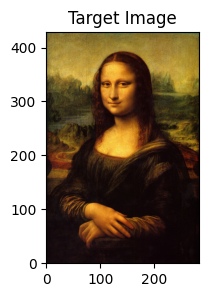

In [ ]:
# Get the target input image as a torch tensor (requires_grad = False)
# Expected in the `data` folder.
file_name = "mona-lisa.png"
target_image: torch.Tensor = get_input_image_as_torch_tensor(file_name)

# Plot
plot(target_image, "Target Image", (4, 3))

# Same as target image pixel dimensions
RES_X = target_image.shape[1]
RES_Y = target_image.shape[0]
x_to_y_ratio = float(RES_X) / float(RES_Y)

X_DIM = (-5.0, 5.0)
Y_DIM = (X_DIM[0]/x_to_y_ratio, X_DIM[1]/x_to_y_ratio)

# New Domain
DOMAIN = Domain2D(x_dim=X_DIM, y_dim=Y_DIM, res_x=RES_X, res_y=RES_Y)

## Part 2.2. Initial random Gaussian parameters for the optimization

In [56]:
N = 100  # Number of Gaussians

# Collect the parameters we want to optimize in a dictionary
params_opt_image = {
    # get random RGB color for N gaussian
    'alphas': nn.Parameter(torch.tensor(
        [[random.random() for _ in range(3)] for _ in range(N)],
        requires_grad=True, device=DEVICE
    )),
    # positions: scatter N random gaussians in our domain
    'centers': nn.Parameter(torch.tensor(
        [[random.uniform(*DOMAIN.x_dim), random.uniform(*DOMAIN.y_dim)] for _ in range(N)],
        requires_grad=True, device=DEVICE
    )),
    # Scales along local (X, Y). Start out with isotropic gaussian
    'sigmas': nn.Parameter(torch.tensor(
        [[0.3, 0.3] for _ in range(N)],
        requires_grad=True, device=DEVICE
    )),
    # Rotations
    'thetas': nn.Parameter(torch.tensor(
        [0.0]*N, # or for random rotation: np.random.rand() * 2 * np.pi
        requires_grad=True, device=DEVICE
    )),
}

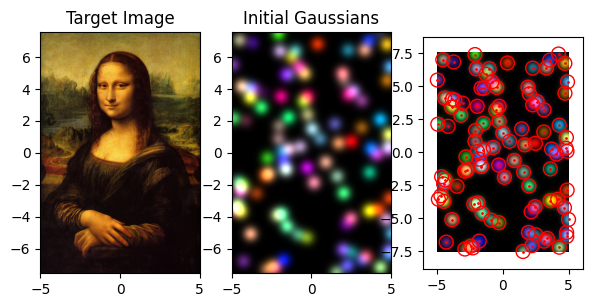

In [57]:
# Plotting initial gaussians
initial_image = reconstruct_image(
    params_opt_image,
    domain=DOMAIN
)

plot(
    data=[target_image, initial_image, initial_image],
    title=["Target Image", "Initial Gaussians", ""],
    outline_params=[None, None, params_opt_image],
    extent=DOMAIN.get_extent(),
    figsize=(7,10)
);

## Part 2.3. Optimization

### Part 2.3.1 Initialize the optimizer

SImilar to the previous optimization section, initialize the learning rate, optimizer, and loss function for Gaussian optimization.

For this notebook, both $L_1$ and $L_2$ losses work fine. In the original 3DGS paper, they add together a D-SSIM loss with a weight of $0.2$ and an $L_1$ loss with a weight of $0.8$ to get their scalar loss.

To find Gaussian parameters $\xi$ that minimize this loss function, we use an Adam optimizer that iteratively steps towards the gradient of the loss w.r.t. the parameters.

In [58]:
# Set per-parameter-group learning rates beyond the default learning rate below.
# We can use this for freezing a given parameter group (e.g. leave particles in the same position).
# For more details on setting up and using the optimizer: https://pytorch.org/docs/stable/optim.html
params_dict_for_optimizer = [
     {'params': params_opt_image['alphas'], 'name': 'alphas'},
     {'params': params_opt_image['centers'], 'name': 'centers'},
     {'params': params_opt_image['sigmas'], 'name': 'sigmas'},
     {'params': params_opt_image['thetas'], 'name': 'thetas'}
]

# (1) Initialize a NEW adam optimizer with the `params_opt_image` parameters, and optionally define a new loss function.

#########
# BEGINNING OF YOUR CODE
#########

lr = 0.01
lr_dict = {'alphas': 0.01, 'centers': 0.01, 'sigmas': 0.01, 'thetas': 0.01}
for i, param_key in enumerate(params_keys):
    if param_key in lr_dict:
        params_dict_for_optimizer[i]['lr'] = lr_dict[param_key]
optimizer = torch.optim.Adam(params_dict_for_optimizer, lr)

#########
# END OF YOUR CODE
#########

### Part 2.3.2. Optimization loop

Similarly to Part 1.3.2, implement the optimization loop by following the steps outlined in the comments below.

In [59]:
# Intervals during optimization
image_save_interval = 1
num_epochs = 500  # number of epochs to optimize for
display_plots = False  # For not cluttering the notebook
save_plots = True  # Writing out images into a folder

if save_plots:
    # Set the output folder to be the current time, and restart naming of the file names
    initialize_file_names()
    print(f"Starting optimization. Outputting results into folder `{CURRENT_SCENE_FOLDER}`.")
else:
    print(f"Starting optimization without saving the results into file.")

timer = Timer()

# Keep track of lost history
loss_trajectory = []

epoch_progress_bar = tqdm(range(num_epochs))
for epoch in epoch_progress_bar:
    # Forward pass, i.e. combining Gaussians into an image
    # Calculate and save current loss between output and target
    # Zero out gradients before running backward pass
    # Compute gradient of the loss (w.r.t. gaussian parameters)
    # Perform an optimization epoch (i.e. update gaussian parameters)

    #############################################
    # BEGINNING OF YOUR CODE
    #############################################

    curr_image = reconstruct_image(params_opt_image, DOMAIN)
    curr_loss = loss_function(curr_image, target_image)

    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()

    loss_trajectory.append(curr_loss.item())

    #############################################
    # END OF YOUR CODE
    #############################################

    for key in params_opt_image:
        torch.nan_to_num(params_opt_image[key])

    with torch.no_grad():
        # Optionally display/save image
        if display_plots or save_plots:
            if epoch % image_save_interval == 0:
                fig = plot(
                    data=[curr_image, curr_image, target_image, loss_trajectory],
                    outline_params=[None, params_opt_image, None, None],
                    title=[
                        f"Optim at epoch {epoch}",
                        f"Gaussians (N={N})",
                        f"Target image",
                        f"Loss history"
                    ],
                    domain=DOMAIN,
                    show_plot=display_plots  # Optionally, don't clutter the notebook with showing the plot here.
                )
            if save_plots:
                # Save plot to file as {curr_date}/{epoch}.jpg
                save_fig_to_file(fig)
            plt.close(fig)  # close the current figure

        # Print out optimization details
        progress_text = (
            f"Step {epoch}, "
            f"Loss: {curr_loss.item()}, "
            f"{timer.get_elapsed_time()}, "
            f"N = {N}"
        )

        epoch_progress_bar.set_description(progress_text)

        # You can experiment with changing the learning rate here
        # if epoch % 800 == 0 and epoch > 0:
        #     for param_group in self.optimizer.param_groups:
        #         param_group['lr'] *= 0.5
        #         print(f"lr: {param_group['lr']}")

Starting optimization. Outputting results into folder `data/2025_03_29-03_02_06`.
Current time: 2025-03-29 03:02:06


Step 499, Loss: 0.03194507956504822, 00:04:03, N = 100: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


### Part 2.3.3. Plotting final result

Create the image/video of your Gaussian optimization for the Mona Lisa target image by running the methods in this section.

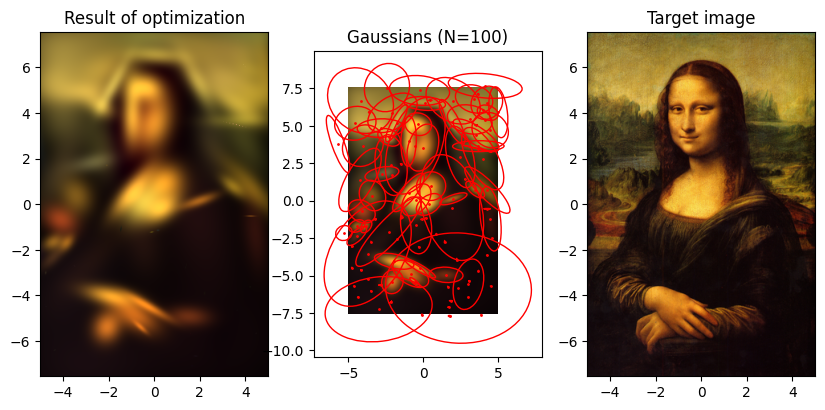

Final params: {'alphas': Parameter containing:
tensor([[ 0.1353,  0.6429,  0.6916],
        [ 0.3559,  0.2854,  0.1168],
        [ 0.1822,  0.4884,  0.3327],
        [-0.0250, -0.0125, -0.0089],
        [ 0.7854,  0.5562,  0.1189],
        [ 0.4992,  0.4099,  0.1518],
        [-0.2432, -0.0398,  0.0350],
        [ 0.5254,  0.4395,  0.1569],
        [ 0.2234,  0.5516,  0.0903],
        [ 0.1086,  0.0569,  0.0366],
        [ 0.1089,  0.4664,  0.0267],
        [ 0.2069,  0.1315,  0.0553],
        [ 0.1734,  0.0603,  0.0383],
        [ 0.8393,  0.7611,  0.2048],
        [ 0.1963,  0.7000,  0.1200],
        [ 0.1265,  0.1074,  0.0247],
        [ 0.6019,  0.4899,  0.5993],
        [ 0.3158,  0.3382,  0.1547],
        [ 0.7004,  0.4663, -0.0889],
        [ 0.3965,  0.4781,  0.3566],
        [ 0.4181,  0.4238,  0.1745],
        [ 0.3565,  0.3579,  0.1597],
        [ 0.3838,  0.3210,  0.1101],
        [-0.1314, -0.3099, -0.0504],
        [ 0.4031,  0.3034,  0.0492],
        [ 0.0432,  0.2713,  

In [ ]:
curr_image = reconstruct_image(params_opt_image, domain=DOMAIN)

# Plotting final result
plot(
    data=[curr_image, curr_image, target_image],
    outline_params=[None, params_opt_image, None],
    title=[
        f"Result of optimization",
        f"Gaussians (N={N})",
        f"Target image"
    ],
    domain=DOMAIN,
    figsize=(10,6)
)

print(f"Final params: {params_opt_image}")

In [ ]:
# Write out the final params into a json data file:
gaussians_to_json_file("optimized-params-image.json", params=params_opt_image, domain=DOMAIN)

2D Gaussian Scene written to data/2025_03_29-02_52_08/optimized-params-image.json.


In [ ]:
assemble_video(CURRENT_SCENE_FOLDER, str("anim-image.mp4"))

Video saved as anim-image.mp4


In [ ]:
# When running the notebook on Google Colab, we can directly show a video, but for some reason it sometimes requires an extra ffmpeg conversion. Thanks to Amrutha Srikanth for this fix.
if IN_COLAB:
    from IPython.display import Video

    !ffmpeg -i anim-image.mp4 -vcodec libx264 anim-image-convert-out.mp4 -loglevel error -y
    display(Video("anim-image-convert-out.mp4", embed=True))

Output hidden; open in https://colab.research.google.com to view.

## Part 2.4. Exporting to a GLSL shader

You can export your final Gaussian parameters into a GLSL shader by running this code and copying the parameters to the highlighted area in the GLSL Shader.

(Thanks to [Molin Deng](https://molin7.vercel.app/home) for the code.)

For submitting the CG in the AI Era homework, see further instructions on [https://cgai-gatech.vercel.app/](https://cgai-gatech.vercel.app/).

For inspiration, here are a couple of cool examples on shadertoy of what you could do with your 2D Gaussian image:
- [https://www.shadertoy.com/view/tflXRB](https://www.shadertoy.com/view/tflXRB)
- [https://www.shadertoy.com/view/dtSfDD](https://www.shadertoy.com/view/dtSfDD)
- [https://www.shadertoy.com/view/MdfGDH](https://www.shadertoy.com/view/MdfGDH)
- [https://www.shadertoy.com/view/4df3D8](https://www.shadertoy.com/view/4df3D8)

In [ ]:
def convert_params_to_glsl(domain, params):
    """
    Converts Gaussian parameters directly to GLSL shader code arrays
    without using packed encoding.

    Args:
        params: Dictionary containing 'alphas', 'centers', 'sigmas', and 'thetas'

    Returns:
        String containing GLSL code for defining the Gaussian arrays
    """
    x_min, x_max = domain.x_dim
    y_min, y_max = domain.y_dim
    # Extract parameters and convert to numpy
    alphas = params['alphas'].detach().cpu().numpy()
    centers = params['centers'].detach().cpu().numpy()
    sigmas = params['sigmas'].detach().cpu().numpy()
    thetas = params['thetas'].detach().cpu().numpy()

    # Get number of Gaussians
    num_gaussians = len(centers)

    # Get maximum sigma value for scale reference
    max_sigma = float(np.max(sigmas))

    # Start building GLSL code
    glsl_code = f"""
// Number of Gaussians
const int NUM_GAUSSIANS = {num_gaussians};
// Dimensions [x_min, x_max, y_min, y_max]
float dim[4] = float[4]({x_min},{x_max},{y_min},{y_max});
// Centers (x, y coordinates)
vec2 gauss_centers[NUM_GAUSSIANS] = vec2[NUM_GAUSSIANS]("""

    # Add center coordinates
    center_lines = []
    for i in range(num_gaussians):
        center_lines.append(f"vec2({centers[i, 0]:.2f}, {centers[i, 1]:.2f})")
    glsl_code += ",".join(center_lines) + ");\n"

    # Add sigmas (scales)
    glsl_code += "// Sigmas (scales)\nvec2 gauss_sigmas[NUM_GAUSSIANS] = vec2[NUM_GAUSSIANS]("
    sigma_lines = []
    for i in range(num_gaussians):
        sigma_lines.append(f"vec2({sigmas[i, 0]:.2f}, {sigmas[i, 1]:.2f})")
    glsl_code += ",".join(sigma_lines) + ");\n"

    # Add rotation angles (thetas)
    glsl_code += "// Rotation angles (thetas)\nfloat gauss_thetas[NUM_GAUSSIANS] = float[NUM_GAUSSIANS]("
    theta_lines = []
    for i in range(num_gaussians):
        theta_lines.append(f"{thetas[i]:.2f}")
    glsl_code += ",".join(theta_lines) + ");\n"

    # Add colors (alphas)
    glsl_code += "// Colors (RGB)\nvec3 gauss_colors[NUM_GAUSSIANS] = vec3[NUM_GAUSSIANS]("
    color_lines = []
    for i in range(num_gaussians):
        color_lines.append(f"vec3({alphas[i, 0]:.2f}, {alphas[i, 1]:.2f}, {alphas[i, 2]:.2f})")
    glsl_code += ",".join(color_lines) + ");\n\n"

    return glsl_code

print(convert_params_to_glsl(DOMAIN, params_opt_image))


// Number of Gaussians
const int NUM_GAUSSIANS = 100;
// Dimensions [x_min, x_max, y_min, y_max]
float dim[4] = float[4](-5.0,5.0,-7.552816901408451,7.552816901408451);
// Centers (x, y coordinates)
vec2 gauss_centers[NUM_GAUSSIANS] = vec2[NUM_GAUSSIANS](vec2(1.75, -7.71),vec2(-2.85, 4.84),vec2(3.67, -4.68),vec2(3.00, -5.58),vec2(-1.95, -4.05),vec2(1.99, 6.66),vec2(-1.45, -1.11),vec2(-2.29, 4.22),vec2(2.23, -3.94),vec2(-0.49, -1.65),vec2(-3.25, -1.25),vec2(-4.45, -2.36),vec2(4.47, -1.21),vec2(-0.99, 3.96),vec2(4.24, -3.65),vec2(4.29, 5.86),vec2(-3.65, 5.89),vec2(4.12, 7.65),vec2(-2.08, 1.68),vec2(4.49, -5.70),vec2(-0.26, 7.35),vec2(-1.79, 5.16),vec2(3.51, 4.36),vec2(-0.55, 3.66),vec2(4.27, 0.70),vec2(3.50, 5.06),vec2(2.76, 1.42),vec2(3.38, 6.78),vec2(4.23, 6.52),vec2(-1.49, 2.45),vec2(3.95, 2.80),vec2(-0.03, 3.53),vec2(-0.47, 0.05),vec2(-2.86, -5.64),vec2(-0.99, 0.54),vec2(3.06, -5.35),vec2(-4.77, -3.04),vec2(-4.54, 5.16),vec2(-0.32, -3.10),vec2(-4.04, 3.66),vec2(4.56, -2.48),vec2(-2.

# Part 3: Render Optimized Gaussians in GLSL Shader

In the final part of this notebook, you must copy your generated Gaussian parameters for the target image and fill in the gaps in the fragment.glsl file to accurately show the list of gaussians.

Your code will include building the inverse covariance matrix needed to place Gaussians in the scene and calculating the contribution of each Gaussian to the overall image field.

This way, you can see your target gaussian splatting image animation on the class website.



# Creative Expression

Find or create an interesting target image and replace our sample image (the Mona Lisa) with it in the loading code block (Part 2.1). Run Part 2 with your new target image and save the results. Feel free to change the number of Gaussians, just make sure to have the same number of colors, positions, scales, and rotations defined in each tensor (i.e. match their first dimension).

## Acknowledgments

This implementation is based on [https://github.com/bobarna/tiny-2d-gaussian-splatting](https://github.com/bobarna/tiny-2d-gaussian-splatting)